In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor

RANDOM_STATE = 42


In [15]:
# Define project directories
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

In [16]:
df = pd.read_csv(DATA_RAW / "house_prices_train.csv")

In [17]:
TARGET_COL = "SalePrice"

# Separate features and target variable
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

In [18]:
train_idx = np.load(SPLITS_DIR / "train_indices.npy")
test_idx = np.load(SPLITS_DIR / "test_indices.npy")

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()

X_test = X.loc[test_idx].copy()
y_test = y.loc[test_idx].copy()

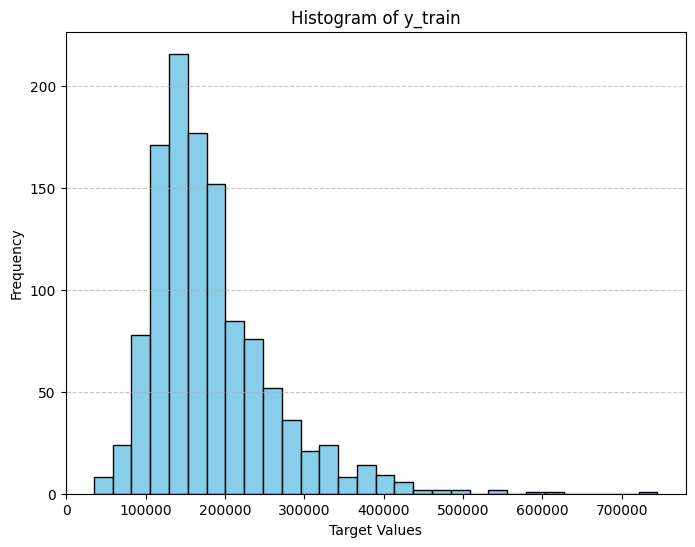

In [19]:
import matplotlib.pyplot as plt

# Plot a histogram for y_train
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of y_train")
plt.xlabel("Target Values")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
# Display descriptive statistics for y_train
y_train.describe()

count      1168.000000
mean     181441.541952
std       77263.583862
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      214925.000000
max      745000.000000
Name: SalePrice, dtype: float64

In [21]:
# Sort y_train in descending order and show the top 10 values
y_train_sorted = y_train.sort_values(ascending=False)

# Convert y_train to a pandas Series (if needed)
y_train_series = pd.Series(y_train)

# Sort and display the top 10 values
y_train_sorted = y_train_series.sort_values(ascending=False)
print(y_train_sorted.head(10))

1182    745000
1169    625000
803     582933
440     555000
769     538000
178     501837
798     485000
185     475000
1373    466500
527     446261
Name: SalePrice, dtype: int64


In [22]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea'

In [23]:
# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)), 
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [24]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [25]:
# Create the full pipeline with preprocessing and model
hgb_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", HistGradientBoostingRegressor(
            max_iter=100,  
            learning_rate=0.1, 
            max_depth=None,  
            random_state=RANDOM_STATE,
            min_samples_leaf=20, 
            max_leaf_nodes=31, 
            early_stopping=True,  
            validation_fraction=0.1, 
        )),
    ]
)

# Create a TransformedTargetRegressor to apply log transformation to the target
log_target_model = TransformedTargetRegressor(
    regressor=hgb_model,
    func=np.log1p,   # forward transform: y -> log1p(y)
    inverse_func=np.expm1,  # inverse transform: y_log -> expm1(y_log)
)

# Perform cross-validation using the log-transformed target values
cv_results_log = cross_validate(
    log_target_model,
    X_train,
    y_train,
    cv=cv,
    scoring=["neg_root_mean_squared_error", "neg_mean_absolute_error"],
    n_jobs=-1,
    return_train_score=False,
)

# Calculate RMSE values from cross-validation results with log-transformed target
rmse_values_log = -cv_results_log["test_neg_root_mean_squared_error"]
rmse_mean_log = rmse_values_log.mean()
rmse_std_log = rmse_values_log.std()

mae_values_log = -cv_results_log["test_neg_mean_absolute_error"]
mae_mean_log = mae_values_log.mean()
mae_std_log = mae_values_log.std()

print(f"Log target CV RMSE: {rmse_mean_log:.2f} ± {rmse_std_log:.2f}")
print(f"Log target CV MAE: {mae_mean_log:.2f} ± {mae_std_log:.2f}")


Log target CV RMSE: 28161.12 ± 4554.00
Log target CV MAE: 16913.54 ± 1274.60


In [26]:
transformation_values = {
    "model": "HistGradientBoostingRegressor_log1p",
    "rmse_mean": rmse_values_log.mean(),
    "rmse_std": rmse_values_log.std(),
    "mae_mean": mae_values_log.mean(),
    "mae_std": mae_values_log.std(),
}

# Load the baseline results CSV into a DataFrame
df_baseline = pd.read_csv(REPORTS_DIR / "metrics_baseline.csv")

# Use 'model' as an index to update or create the HGB row
df_baseline = df_baseline.set_index("model")

# Update or create the HGB row
df_baseline.loc["HistGradientBoostingRegressor_log1p", ["rmse_mean", "rmse_std", "mae_mean", "mae_std"]] = [
    transformation_values["rmse_mean"],
    transformation_values["rmse_std"],
    transformation_values["mae_mean"],
    transformation_values["mae_std"],
]

# Reset index back to a normal column and save to CSV
df_baseline = df_baseline.reset_index()
df_baseline.to_csv(REPORTS_DIR / "metrics_baseline.csv", index=False)

# Display the updated DataFrame
print(df_baseline)

                                 model     rmse_mean     rmse_std  \
0                           Dummy_mean  77160.108457  3673.252798   
1                    Linear_Regression  36397.273713  7544.717946   
2                      Ridge_alpha_1.0  32814.497631  7332.537866   
3                      Lasso_alpha_0.1  36039.211360  7401.016075   
4                RandomForestRegressor  30187.811059  4925.198978   
5                    Lasso_alpha_100.0  31597.031137  7633.433043   
6                     Ridge_alpha_10.0  31556.174539  7216.615113   
7        HistGradientBoostingRegressor  28748.832334  4848.514218   
8  HistGradientBoostingRegressor_log1p  28161.121614  4554.002726   

       mae_mean      mae_std  
0  56318.232277  2612.148500  
1  19621.981805   806.121901  
2  18676.071378  1116.810159  
3  19444.763807   899.418995  
4  18172.212787  1123.688346  
5  20612.670160   857.574200  
6  18001.482651   581.320602  
7  17057.678687   995.424645  
8  16913.540464  1274.597289  